In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

In [2]:
Y_total = np.loadtxt('data/data.txt').astype(int)
movies = np.loadtxt('data/movies.txt', dtype='str', delimiter='\t')
movie_names = dict([(int(movie[0]), movie[1]) for movie in movies])
movie_labels = movies[:,2:].astype('float')
M = max(Y_total[:,0]).astype(int) # users
N = max(Y_total[:,1]).astype(int) # movies

In [2]:
def get_err(U, V, Y, reg=0.0, use_bias=False, a=None, b=None):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V. a is the vector of biases for each user and
    b is the vector of biases for each movie.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    reg_term = reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2) / 2
    err = 0 
    for y in Y:
        i = y[0] - 1
        j = y[1] - 1
        Y_ij = y[2]
        if use_bias:
            err += (Y_ij - np.dot(U[i], V[j]) - a[i] - b[j])**2
        else:
            err += (Y_ij - np.dot(U[i], V[j]))**2
    return (reg_term + (err / 2) )/ float(len(Y))

In [3]:
def grad_U(Ui, Yij, Vj, reg, eta, use_bias=False, ai=None, bj=None):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    if use_bias:
        grad = - Vj * (Yij - np.dot(Ui, Vj) - ai - bj)
    else:
        grad = - Vj * (Yij - np.dot(Ui, Vj))
    return (Ui * reg + grad) * eta

def grad_V(Vj, Yij, Ui, reg, eta, use_bias=False, ai=None, bj=None):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    if use_bias:
        grad = - Ui * (Yij - np.dot(Ui, Vj) - ai - bj)
    else:
        grad = - Ui * (Yij - np.dot(Ui, Vj))
    return (Vj * reg + grad) * eta

def grad_a(Ui, Yij, Vj, reg, eta, ai, bj):
    grad = -(Yij - np.dot(Ui, Vj) - ai - bj)
    return (reg * ai + grad) * eta

def grad_b(Ui, Yij, Vj, reg, eta, ai, bj):
    grad = -(Yij - np.dot(Ui, Vj) - ai - bj)
    return (reg * bj + grad) * eta

def train_model_use_bias(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    a = np.random.rand(M,) - 0.5
    b = np.random.rand(N,) - 0.5

    for epoch in range(max_epochs):
        curr_loss = get_err(U, V, Y, reg, use_bias=True, a=a, b=b)

        rand_perm = np.random.permutation(list(range(len(Y))))
        for index in rand_perm:
            i = Y[index][0] - 1
            j = Y[index][1] - 1
            Y_ij = Y[index][2]
            Ui = U[i]
            Vj = V[j]
            ai = a[i]
            bj = b[j]
            U[i] -= grad_U(Ui, Y_ij, Vj, reg, eta, use_bias=True, ai=ai, bj=bj)
            V[j] -= grad_V(Vj, Y_ij, Ui, reg, eta, use_bias=True, ai=ai, bj=bj)
            a[i] -= grad_a(Ui, Y_ij, Vj, reg, eta, ai, bj)
            b[j] -= grad_b(Ui, Y_ij, Vj, reg, eta, ai, bj)


        if epoch == 1:
            first_dec = curr_loss - get_err(U, V, Y, reg, use_bias=True, a=a, b=b)

        elif epoch > 1:
            dec = curr_loss - get_err(U, V, Y, reg, use_bias=True, a=a, b=b)

            if dec <= eps * first_dec:
                break
    
    return (U, V, a, b, get_err(U, V, Y, reg, use_bias=True, a=a, b=b))

In [7]:
U_method2, V_method2, a, b, err_method2 = train_model_use_bias(M,N,20,0.1,0.1,Y_total)

## Visualize

In [56]:
def plot_projections(U_in, V_in, plot_title, V_indices_0, V_indices_1, label_names, filename=None):
    '''
    V_indices_0 is a list of indices of the movies that we want to plot (category 0)
    V_indices_1 is a list of indices of the movies that we want to plot (category 1)
    label_names is a tuple of strings, label_names[0] is the name of movies labeled 0
    '''
    U = np.zeros(U_in.shape)
    V = np.zeros(V_in.shape)
    
    # Normalize
    for i in range(len(V[0])):
        avg = V_in[:,i].mean()
        std = V_in[:,i].std()
        V[:,i] = (V_in[:,i] - avg) / std
        U[:,i] = (U_in[:,i] - avg) / std
        
    A, Sigma, B = np.linalg.svd(V.T)
    Vproj = np.dot(A[:,:2].T, V.T)
    Uproj = np.dot(A[:,:2].T, U.T)
    
    Vproj_new_0 = [[],[]] # 0th category
    Vproj_new_1 = [[],[]] # 1st category
    
    for i in range(2):
        for idx in V_indices_0:
            Vproj_new_0[i].append(Vproj[i][idx])
        for idx in V_indices_1:
            Vproj_new_1[i].append(Vproj[i][idx])
            
    # Plot
    plt.plot(Vproj_new_0[0], Vproj_new_0[1], "o", label=label_names[0])
    plt.plot(Vproj_new_1[0], Vproj_new_1[1], "o", label=label_names[1])
    
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    
    plt.title(plot_title)
    if filename != None:
        plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.clf()
    plt.cla()

## Plot highest rated vs. lowest rated movies

sorting finished


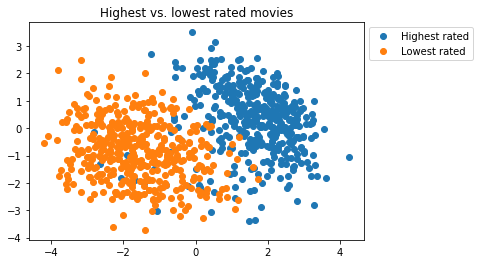

In [57]:
# Compute average rating for each movie
movie_ratings = {}  # a dictionary of lists, key: movie_id, value: list of ratings 
for line in Y_total:
    user_id = line[0] 
    movie_id = line[1]
    rating = line[2]
    # If the list of ratings for this movie isn't initialized
    if not (movie_id in movie_ratings):
        movie_ratings[movie_id] = []
    # Append the new rating we found in Y_total
    movie_ratings[movie_id].append(rating)
avg_ratings = []
for movie_id in range(1, N+1):
    avg_ratings.append(np.mean(movie_ratings[movie_id]))
    
# Sort (movie_id, avg_rating) from highest rated to lowest
movie_ids= np.array(range(1, N+1))
high_rankings = sorted(zip(movie_ids, avg_ratings),key = lambda x: x[1], reverse=True)
print("sorting finished")

# Extract the indices of the best quarter and the worst quarter
best_ids, best_avg_ratings = zip(*high_rankings[:int(N//4)])
worst_ids, worst_avg_ratings = zip(*high_rankings[-int(N//4):])

best_indices = np.array(best_ids) - 1
worst_indices = np.array(worst_ids) - 1
label_names = ("Highest rated", "Lowest rated")

# Scatter plot of highest ranked movies versus lowest ranked movies
plot_projections(U_method2, V_method2, "Highest vs. lowest rated movies",
                 best_indices, worst_indices, label_names,
                 "interesting_high_v_low")

## Plot movies of musical and thriller genres

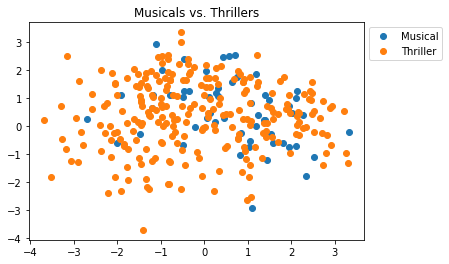

In [58]:
musical = []
thriller = []
for line in movies:
    if line[14] == "1":
        musical.append(int(line[0]) - 1) # append movie index
    elif line[18] == "1":
        thriller.append(int(line[0]) - 1)
musical = np.array(musical).astype('int')
thriller = np.array(thriller).astype('int')
label_names = ("Musical", "Thriller")
plot_projections(U_method2, V_method2, "Musicals vs. Thrillers",
                 musical, thriller, label_names,
                 "interesting_musical_v_thriller")

In [59]:
# sort the genres by number of movies
genre_count = {}
for g in range(2, 21):
    genre_count[g] = np.sum(movies[:, g].astype(int))
print(genre_count)

{2: 2, 3: 251, 4: 135, 5: 42, 6: 122, 7: 505, 8: 109, 9: 50, 10: 725, 11: 22, 12: 24, 13: 92, 14: 56, 15: 61, 16: 247, 17: 101, 18: 251, 19: 71, 20: 27}


## Plot movies of horror and comedy genres

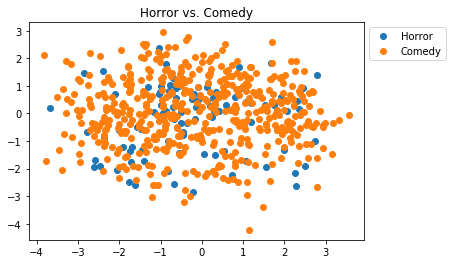

In [60]:
horror = []
comedy = []
for line in movies:
    if line[13] == "1":
        horror.append(int(line[0]) - 1) # append movie index
    elif line[7] == "1":
        comedy.append(int(line[0]) - 1)
label_names = ("Horror", "Comedy")
plot_projections(U_method2, V_method2, "Horror vs. Comedy",
                 horror, comedy, label_names,
                 "interesting_horror_v_comedy")